In [1]:
#This is a dummy comment to check for the branch functionality with Git.

#Import libraries and functions

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import glob #pattern package to find filename
from skimage.io import imread
from scipy import ndimage
from scipy.ndimage import shift
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.interpolation import rotate
from scipy.optimize import curve_fit

In [2]:
#Define functions

def roi_mask_in(x, y, r):
    x = np.arange(1024) - x
    y = np.arange(1024) - y
    X, Y = np.meshgrid(x, y)
    #R = np.sqrt(X**2 + Y**2)
    #theta = np.arctan2(X, Y)
    return (np.abs(X) < r)*(np.abs(Y) < r)

Loaded 70 images


<IPython.core.display.Javascript object>


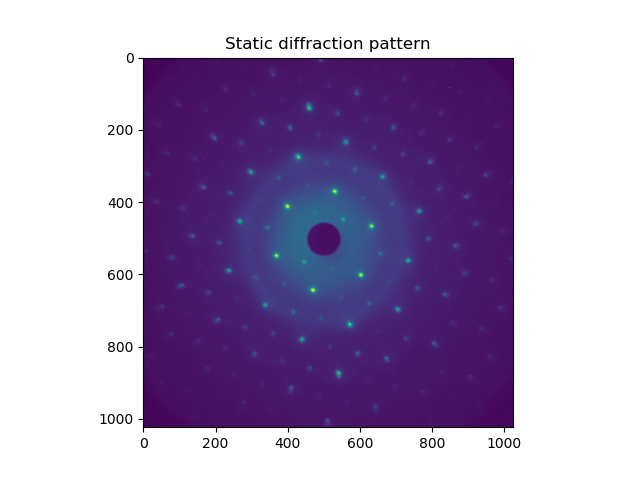

Text(0.5, 1.0, 'Static diffraction pattern')

In [3]:
#Import files

path = 'C:/Users/hmp5210/OneDrive/Research/Ultrafast Optics/SLAC/August 2019/UED data (August 2019)/20190804/Run/20190804_2317/'
path_save = 'C:/Users/hmp5210/OneDrive/Research/Ultrafast Optics/SLAC/August 2019/Processed data/20190804_2317/'
n_scans = 30

fname = glob.glob(path + 'scan001/images-ANDOR1/*.tif')
#print(fname)

imgs = [imread(f).astype(np.float32) for f in fname]
n_imgs = ((np.shape(imgs))[0])
print('Loaded %d images'%n_imgs)

imgs_sum = np.zeros((1024,1024))

for i in np.arange(n_imgs):
      imgs_sum = imgs_sum + imgs[i]
      i = i + 1
      
imgs_ave_static = imgs_sum/n_imgs

plt.figure()
plt.imshow(np.log(imgs_ave_static))
plt.title('Static diffraction pattern')

<IPython.core.display.Javascript object>


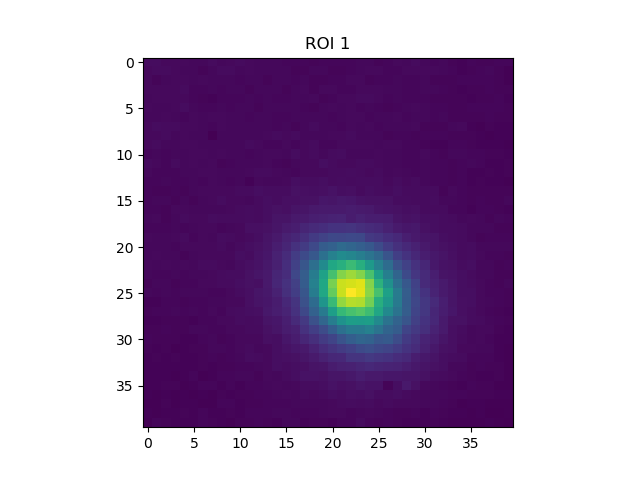

Fitted parameters
[5.07888764e+00 2.23950860e+01 2.48176891e+01 3.65782413e+00
 3.45249525e+00 2.06061778e-04 2.30464823e-04 1.08025333e+00]


<IPython.core.display.Javascript object>


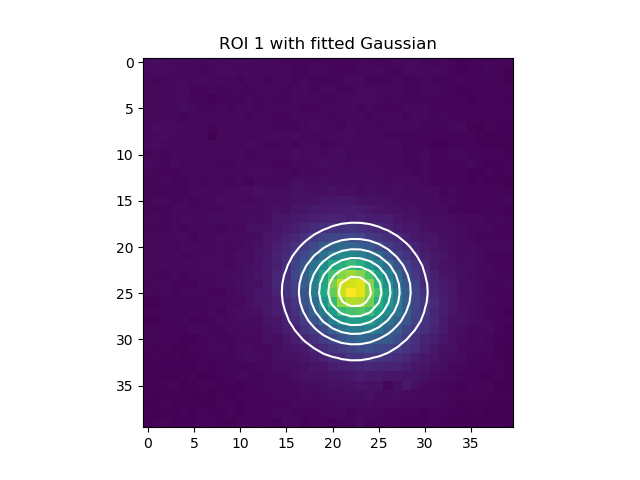

In [4]:
#Extract a ROI and fit Gaussian - use to check curve fitting procedure on single image
#Do not delete, since functions and variables are defined here!

roi_x = 702
roi_y = 693
roi_r = 20

norm_factor = np.mean(imgs_ave_static)

imgs_ave_roi1 = imgs_ave_static[roi_y-roi_r : roi_y+roi_r, roi_x-roi_r : roi_x+roi_r] 
#Note that image x-y is switched with array row-column

##Constructing x-y meshgrid with the ROI data as z(x,y)
x = np.linspace(0, roi_r*2-1, roi_r*2)
y = np.linspace(0, roi_r*2-1, roi_r*2)
X, Y = np.meshgrid(x,y)
Z = imgs_ave_roi1/norm_factor #normalizing ROI with the total intensity

##Plotting ROI
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(imgs_ave_roi1)
plt.title('ROI 1')

##Defining a Gaussian function
def gaussian(x, y, a, x0, y0, sig_x, sig_y, b, c, d):
    return a*(np.exp(-(x-x0)**2/(2*sig_x**2) -(y-y0)**2/(2*sig_y**2))) + b*x + c*y + d

##Defining a Gaussian function with ravelled arrays as the inputs and output
def ravelled_gaussian(M, *args):#M is a 2xN array where N is the total number of pixels in the ROI
    x, y = M
    arr = gaussian(x, y, *args)#defining the fitting function in the ravelled form
    return arr

##Ravelling x-y meshgrid with z data into 1D arrays
xy_ravel = np.vstack((np.ravel(X),np.ravel(Y)))
z_ravel = np.ravel(Z)

##Fitting data in ravelled 1D form
fit_init = [np.max(imgs_ave_roi1), roi_r, roi_r, roi_r/4, roi_r/4, np.max(imgs_ave_roi1)/100, np.max(imgs_ave_roi1)/100, np.max(imgs_ave_roi1)/10]

popt, pcov = curve_fit(ravelled_gaussian, xy_ravel, z_ravel, fit_init)

fit = gaussian(X, Y, *popt)
print('Fitted parameters')
print(popt)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z)
ax.contour(X, Y, fit, colors='w')
plt.title('ROI 1 with fitted Gaussian')
plt.show()                 

In [5]:
#Import files and delay positions

##Import files
fname = glob.glob (path + 'scan001/images-ANDOR1/*.tif')  
#automatically sorts
#print('Length of filename = ',len(fname[0]))
#print('File name = ', fname[0])
#print('Number of files in each scan = ', len(fname))
#print('')

##Extract delay stage positions
string_start = 162 #start position to extract delay stage position in the filename 
string_end = 174 #stop position to extract delay stage position in the filename

delay_strings = []

for i in np.arange(0,len(fname),1):
    delay_strings.append(fname[i][string_start:string_end])
    
n_acq = int(len(delay_strings)/len(list(set((delay_strings)))))
    
delay_strings = list(set(delay_strings)) #remove duplicates
#print(delay_stage_strings) 

delay = []
for i in np.arange(0, len(delay_strings), 1):
    delay.append(float(delay_strings[i]))

delay = sorted(delay)
delay = np.asarray(delay)
#print(delay)

##Extract all files and classify according to delay stage position

imgs_tr = np.zeros((len(delay), 1024, 1024))
norm_factor = np.zeros((len(delay)))

for i in np.arange(0, len(delay)):
    
    fname = glob.glob(path + 'scan0*/images-ANDOR1/ANDOR1_longDelay-*-%12.8f*.tif' %delay[i])
    temp_imgs = [imread(f).astype(np.float32) for f in fname] 
    n_imgs = (np.shape(temp_imgs))[0]
    
    for j in np.arange(0, n_imgs):
        imgs_tr[i] += temp_imgs[j]
    
    imgs_tr[i] = imgs_tr[i]/n_imgs #taking the average
    norm_factor[i] = np.mean(imgs_tr[i])
    imgs_tr[i] = imgs_tr[i]/norm_factor[i]

<IPython.core.display.Javascript object>


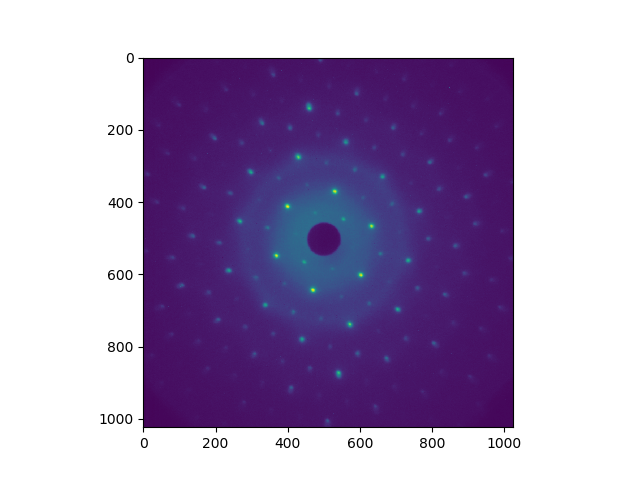

In [6]:
#Select Bragg peaks to analyze using mouseclicks

fig, ax = plt.subplots()
ax.imshow(np.log(imgs_ave_static))

bragg_peak_coords = []

def onclick(event):
    bragg_peak_coords.append([event.xdata, event.ydata])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [7]:
bragg_peak_coords = np.array(bragg_peak_coords)
bragg_peak_coords = bragg_peak_coords.astype(int)
print(bragg_peak_coords)

[[528 369]
 [467 643]
 [397 411]
 [600 605]
 [364 546]
 [633 466]]


In [264]:
#bragg_peak_coords[4] = [424, 273]
#bragg_peak_coords

<IPython.core.display.Javascript object>


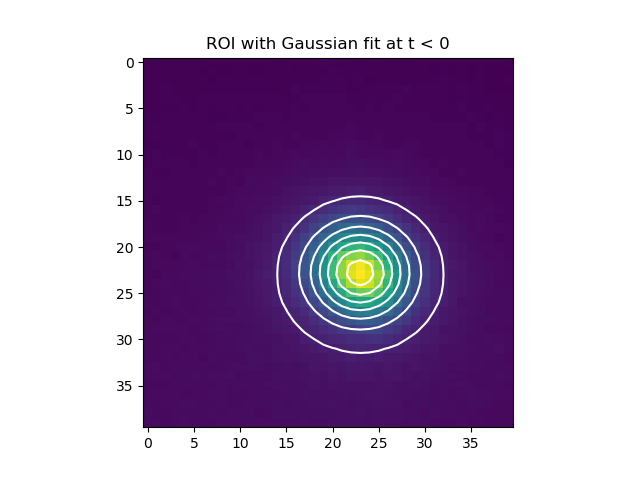

<IPython.core.display.Javascript object>


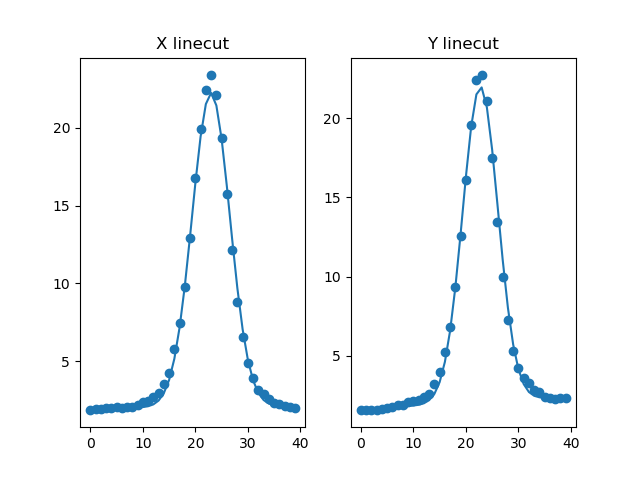

<IPython.core.display.Javascript object>


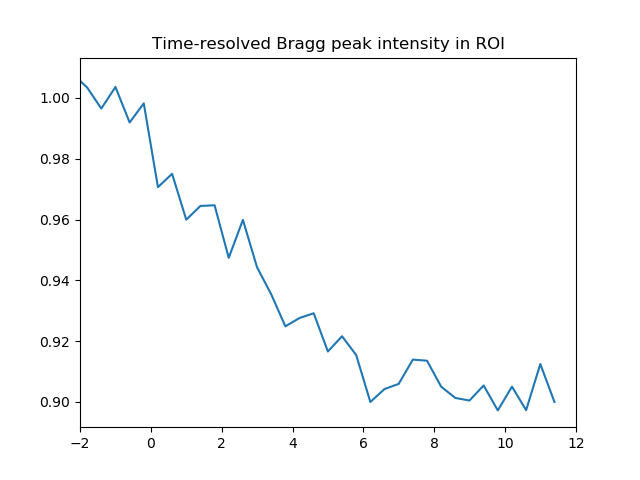

<IPython.core.display.Javascript object>


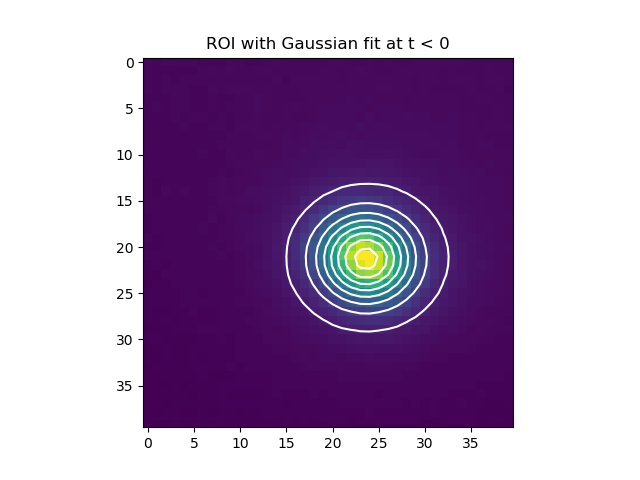

<IPython.core.display.Javascript object>


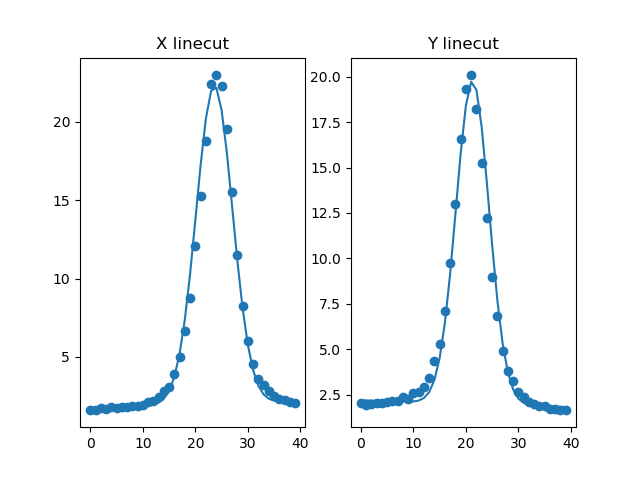

<IPython.core.display.Javascript object>


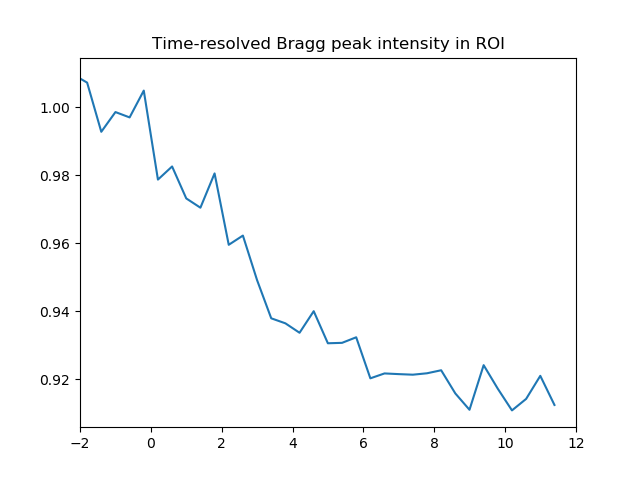

<IPython.core.display.Javascript object>


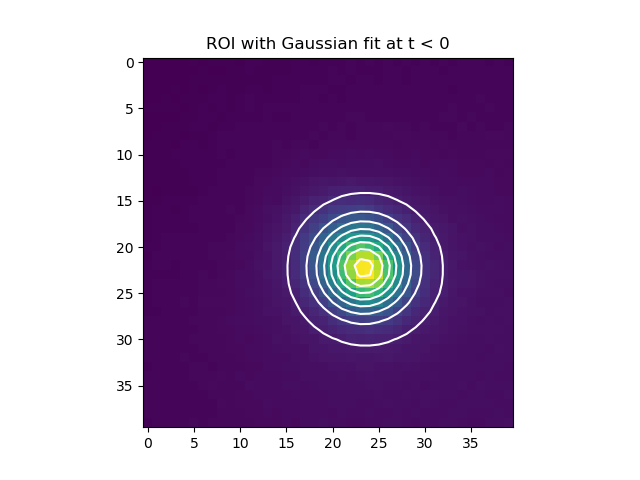

<IPython.core.display.Javascript object>


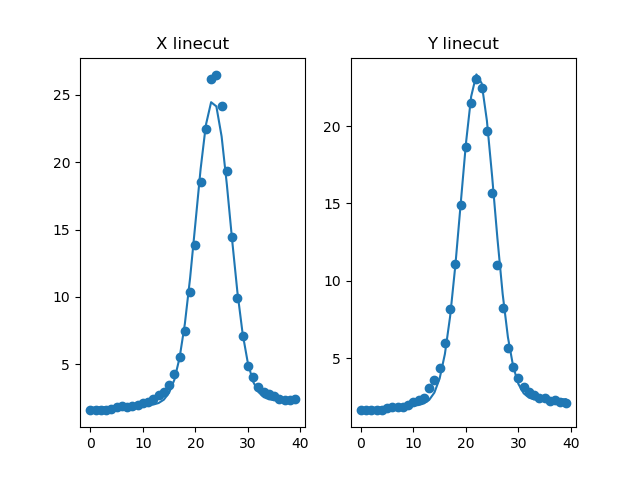

<IPython.core.display.Javascript object>


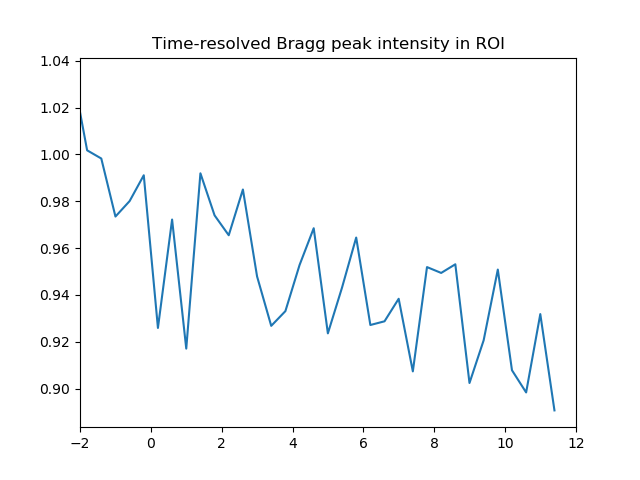

<IPython.core.display.Javascript object>


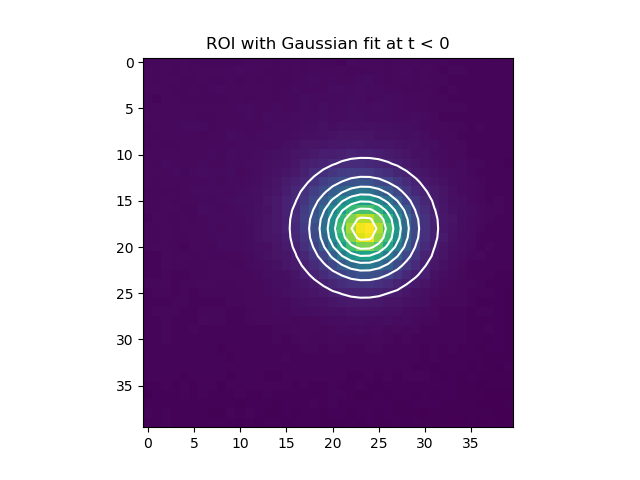

<IPython.core.display.Javascript object>


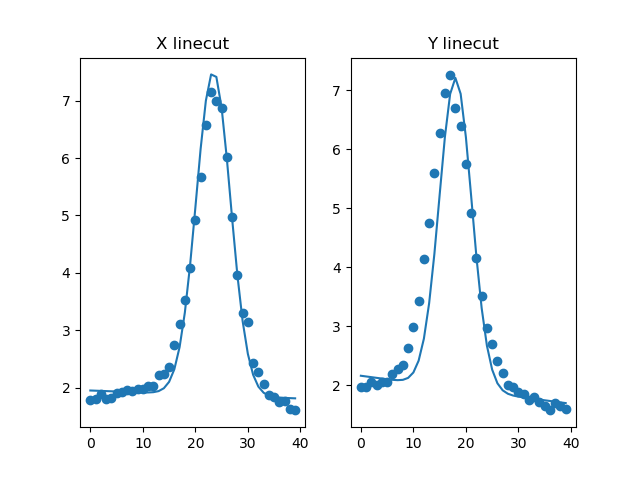

<IPython.core.display.Javascript object>


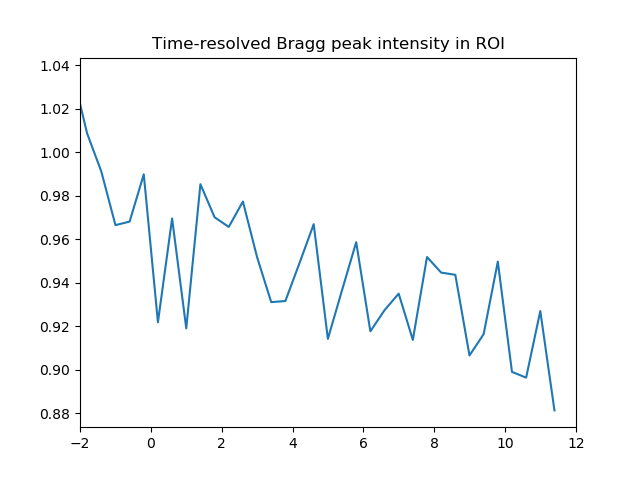

<IPython.core.display.Javascript object>


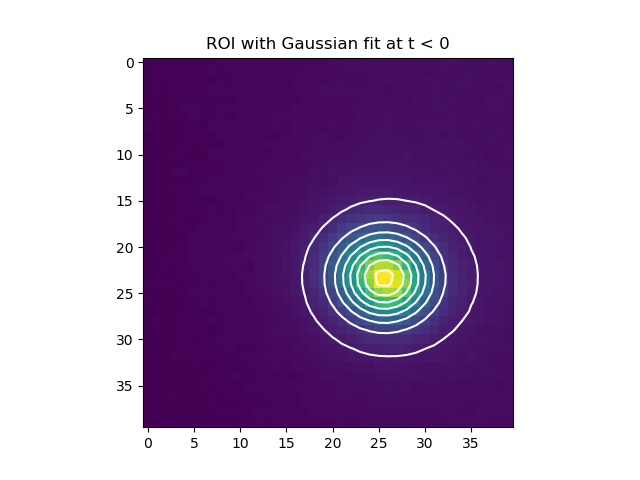

<IPython.core.display.Javascript object>


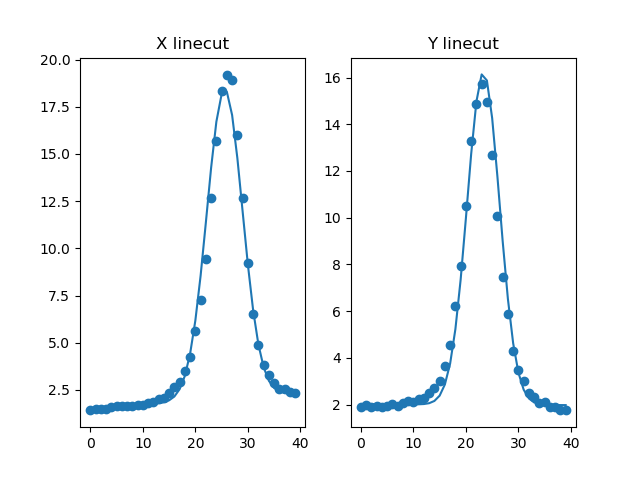

<IPython.core.display.Javascript object>


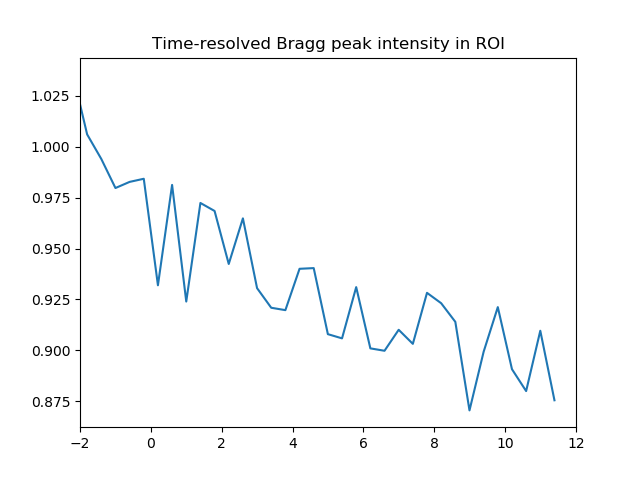

<IPython.core.display.Javascript object>


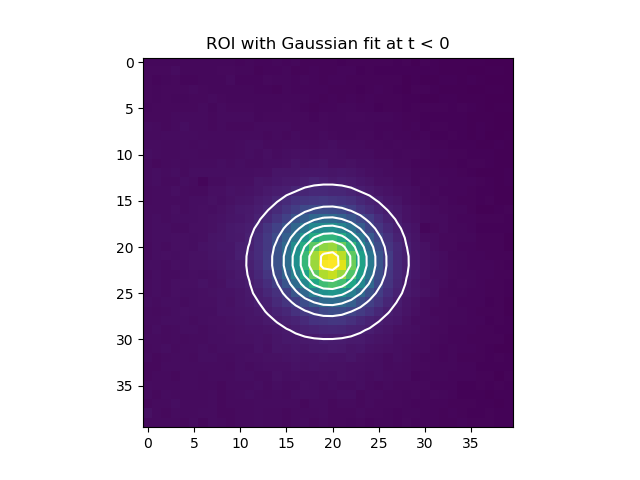

C:\Users\hmp5210\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


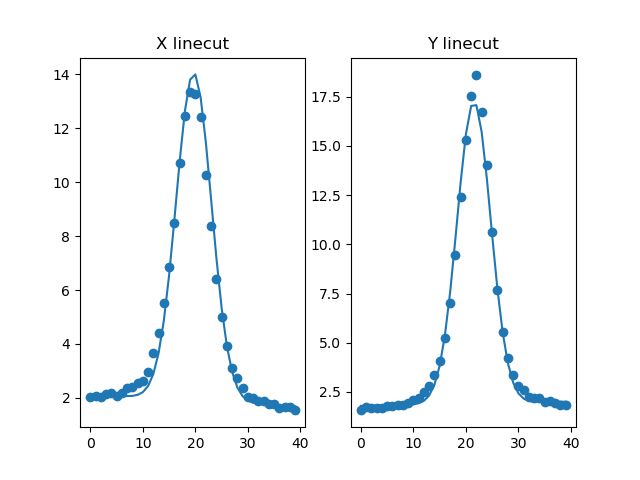

C:\Users\hmp5210\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


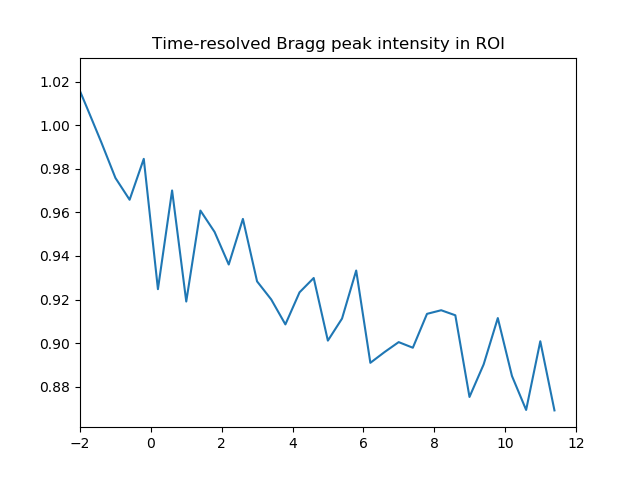

In [8]:
#Time-resolved dynamics of chosen Bragg peaks

bragg_vs_delay_sum = 0*delay

##Looping over all chosen Bragg peaks
for k in np.arange(0, len(bragg_peak_coords)):

    ##Extract a ROI #rows --> y, columns --> x
    roi_x = (bragg_peak_coords[k,0])
    roi_y = (bragg_peak_coords[k,1])
    roi_r = 20

    imgs_tr_roi = imgs_tr[:, roi_y-roi_r:roi_y+roi_r, roi_x-roi_r:roi_x+roi_r] #rows --> y, columns --> x

    imgs_tr_roi_ravel = []

    popt = np.zeros((len(delay),8))
    pcov = []

    ##Looping over all time delays
    for i in np.arange(0, len(delay)):
        imgs_tr_roi_ravel.append(np.ravel(imgs_tr_roi[i]))

        ##Fitting data in ravelled 1D form
        fit_init = [np.max(imgs_tr_roi[i]), roi_r, roi_r, roi_r/4, roi_r/4, np.max(imgs_tr_roi[i])/100, np.max(imgs_tr_roi[i])/100, np.max(imgs_tr_roi[i])/10]
    
        popt[i] = ((curve_fit(ravelled_gaussian, xy_ravel, imgs_tr_roi_ravel[i], fit_init))[0])
        #pcov = ((curve_fit(ravelled_gaussian, xy_ravel, imgs_tr_roi_ravel[i], fit_init))[1])

    #print(popt[:,0])
    
    ##Plotting ROI at t < 0 for each Bragg peak
    fit = gaussian(X, Y, *popt[0])

    fig = plt.figure()
    plt.imshow(imgs_tr_roi[0])
    plt.contour(X, Y, fit, colors='w') 
    plt.title('ROI with Gaussian fit at t < 0')

    fig = plt.figure()
    
    fit_row = int(popt[0,1])
    fit_col = int(popt[0,2])
    
    ax = fig.add_subplot(121)
    ax.scatter(x,imgs_tr_roi[0, fit_row, :])
    ax.plot(x, fit[fit_row,:])
    ax.set_title('X linecut') #note again, row# --> image y, column# --> image x
    
    ax = fig.add_subplot(122)
    ax.scatter(x, imgs_tr_roi[0, :, fit_col])
    ax.plot(x, fit[:,fit_col])  
    ax.set_title('Y linecut')

    ##Plotting time-resolved amplitude of Gaussian fit
    delay_time = (-delay + 272.1)/0.15
    i0 = np.mean(popt[len(popt)-3:len(popt)-1,0]*popt[len(popt)-3:len(popt)-1,3]*popt[len(popt)-3:len(popt)-1,4]) #average of intensity before t = 0 to normalize
    
    bragg_vs_delay = popt[:,0]*popt[:,3]*popt[:,4]/i0
    bragg_vs_delay_sum = bragg_vs_delay_sum + bragg_vs_delay
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111)
    
    ax.plot(delay_time, popt[:,0]*popt[:,3]*popt[:,4]/i0)
    ax.set_title('Time-resolved Bragg peak intensity in ROI')     
    ax.set_xlim(-2, 12)   

In [381]:
np.savetxt(path_save + 'delay.txt', delay_time)
np.savetxt(path_save + 'bragg_dynamics_520.txt', bragg_vs_delay_sum/5)

In [47]:
#fit_init = [0.5, 1]

#def bragg_fit_fn(t, a1, taud1):
#    if(t < 0):
#        return a1*0 + 1
#    else:
#        return a1*np.exp(-t/taud1) + 1 - a1

#popt, pcov = curve_fit(bragg_fit_fn, delay_time, bragg_vs_delay_sum, fit_init)

#fit = bragg_fit_fn(delay_time, *popt)

#print('Fitted parameters')
#print(popt)

#fig = plt.figure()
    
#plt.scatter(delay_time, bragg_vs_delay_sum)
#plt.plot(delay_time, fit)
#plt.title('Time-resolved Bragg peak intensity in ROI')      
